In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt
import matplotlib.pyplot as pl
import scipy.stats
import scipy.optimize
import astropy.time
import astropy.units as u
import astropy.constants as c
import emcee
import corner

# For running on Colaboratory
# ! pip install corner
# ! pip install emcee

custom_mplstyle = ("https://raw.githubusercontent.com/FoxFortino"
                   "/DSPS_WFortino/main/custom.mplstyle")
plt.style.use(custom_mplstyle)

In [2]:
def line(m, b, x):
    return m * x + b

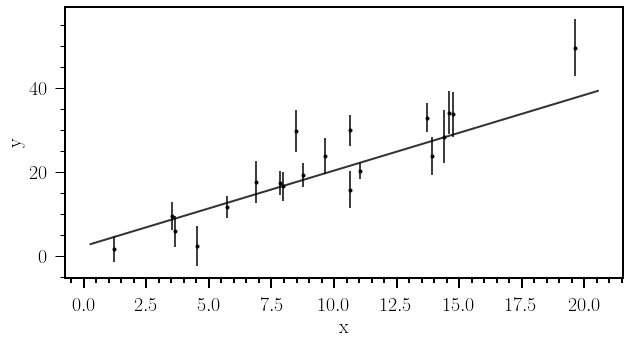

Figure 1: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors


In [3]:
# Choose the "true" parameters.
m_true = 1.8
b_true = 2.3

# Generate some synthetic data from the model.
N = 20
np.random.seed(123)
x = np.sort(np.random.rand(N) * 20)
y = line(m_true, b_true, x)
yerr = np.sqrt(y) + np.random.randn(N) 
y += yerr * np.random.randn(N) 

ax = plt.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(plt.xlim(), line(m_true, b_true,  np.array(plt.xlim())), 'k-', alpha=0.8, lw=2)

plt.show()
print ("Figure 1: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors")

In [4]:
# what do I know about my model? e.g. the slope should be between 0 and 90 degree
def lnprior(theta):
    m, b = theta
    if -10 < b < 10 and 0 < m < 10 :
        return 0.0
    return -np.inf

In [5]:
#remember the chi square: 
# Sum((model - data)/error)^2 is a quantity that follows a chi square distribution with N=number of degreed of freedom. 
# Divide it by the number of degreed  of freedom as Chisq = (Sum((model - data)/error)^2)/DOF
# If it is ~1 that is a good model. 
# >1 bad model
# <1 your errors must be underestimated (model too good to be true!)

def lnlike(theta, x, y, yerr):
    m, b = theta
    return -0.5*(np.sum((line(m, b, x) - y)**2 / (yerr**2)))

In [6]:
np.random.seed(666)

theta_current = (m_true, b_true) + np.random.randn(2)
print("theta_0 = ", theta_current)

# we start the walk here
walk = [theta_current]

# proposed perturbation of the current position - gaussian with width 0.5
proposal_width = (0.2, 0.2) 
proposal = scipy.stats.norm(theta_current, proposal_width).rvs()

# current values  of the pieces of Bayes theorem
ln_current = lnlike(theta_current, x, y, yerr)
prior_current = lnprior(theta_current)

# values  of the pieces of Bayes theorem at the proposed position
ln_proposal  = lnlike(proposal, x, y, yerr)
prior_proposal = lnprior(proposal)

# put them together
p_current = np.exp(ln_current + prior_current)
p_proposal = np.exp(ln_proposal + prior_proposal)
print("p current {:.2g}".format(p_current))
print("p new {:.2g}".format(p_proposal))

theta_0 =  [2.62418808 2.779966  ]
p current 1.2e-23
p new 2.7e-37


In [7]:
N = 10000 #number of steps in my chain

# move along the walk N = 100, 1000 steps
np.random.seed(666)

theta_current = (m_true, b_true) + np.random.randn(2)

# we start the walk here
walk = [theta_current]

# propoed perturbation of the current position - gaussian with width 0.5
proposal_width = (0.2, 0.2) 

# current values  of the pieces of Bayes theorem
ln_current = lnlike(theta_current, x, y, yerr)
prior_current = lnprior(theta_current)

p_current = np.exp(ln_current + prior_current)

for i in range(N):
    
    # calculate the proposal and the prior  and likelihood there
    proposal = scipy.stats.norm(theta_current, proposal_width).rvs()
    ln_proposal  = lnlike(proposal, x, y, yerr)
    prior_proposal = lnprior(proposal)
    p_proposal = np.exp(ln_proposal + prior_proposal)
    
    # update for sure if it is a better location
    if p_proposal > p_current:
        #print ("right away")
        theta_current, ln_current, prior_current, p_current = \
        proposal, ln_proposal, prior_proposal, p_proposal
        walk.append(proposal)
        
    #update with a probability equal to the posteriors ratio if the location is worse
    else:
        p_accept = (p_proposal / p_current)
        
        #use a stocastic draw to accept with probability P
        if np.random.rand() < p_accept:
            #print ("later on away")

            theta_current, ln_current, prior_current, p_current = proposal, ln_proposal, prior_proposal, p_proposal
            walk.append(proposal)
m_mcmc = np.percentile(np.array(walk)[:,0], [50, 16, 84])
b_mcmc = np.percentile(np.array(walk)[:,1], [50, 16, 84])
mcmcRes = np.concatenate([m_mcmc, b_mcmc])
print ("MCMC result:\nslope\t\t{0:+.2f} ({1:.2f}, {2:.2f})\nintercept\t{3:.2f} ({4:.2f}, {5:.2f})".format(*mcmcRes))

MCMC result:
slope		+2.26 (2.07, 2.44)
intercept	-1.17 (-2.82, 0.49)


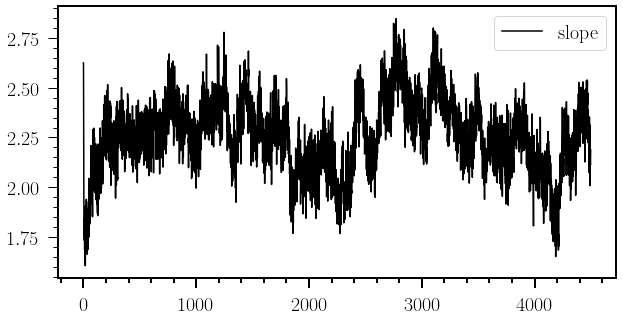

Fig 2:  slope MCMC chain


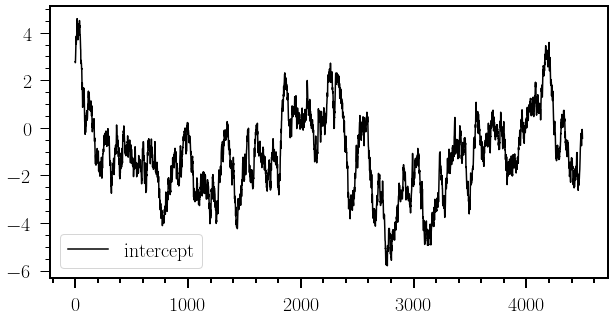

Fig 3:  intercept MCMC chain


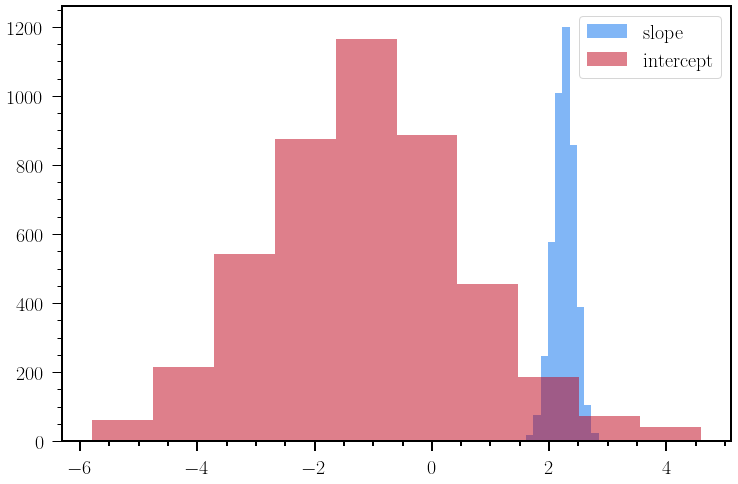

Fig 4:  slope and intercept MCMC posterior distributions


In [8]:

# look at the sampled posterior  space
pl.figure(figsize=(10,5))
pl.plot(np.array(walk)[:,0],'k-', label="slope")
pl.legend()
pl.show()
print ("Fig 2:  slope MCMC chain")

pl.figure(figsize=(10,5))
pl.plot(np.array(walk)[:,1], 'k-', label="intercept")
pl.legend()
pl.show()
print ("Fig 3:  intercept MCMC chain")

pl.figure()
pl.hist(np.array(walk)[:,0], alpha=0.5, label="slope")

pl.hist(np.array(walk)[:,1], alpha=0.5, label="intercept")
pl.legend()
pl.show()
print ("Fig 4:  slope and intercept MCMC posterior distributions")

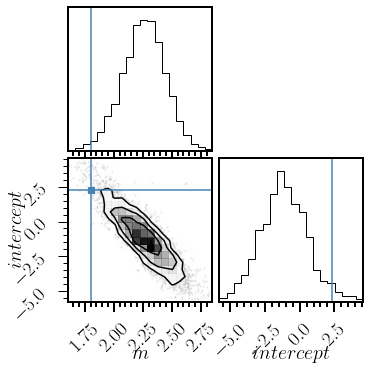

Fig 5: posterior joint distribution - generative model truth indicated in blue


In [9]:
fig = corner.corner(np.array(walk), labels=["$m$","$intercept$"],
                   truths=(m_true, b_true))
pl.show()
print ("Fig 5: posterior joint distribution - generative model truth indicated in blue")

# EMCEE

In [10]:
# ENCEE needs a lnprob function to put together prior and posterior (in log space)
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [11]:
start = np.array([m_true, b_true])
ndim, nwalkers, nsteps = start.shape[0], 100, 5000
pos = [start + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# pos

In [12]:
#create the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
#run the sampler model
final_state = sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 5000/5000 [00:13<00:00, 367.38it/s]


In [13]:
sampler.get_chain().shape

(5000, 100, 2)

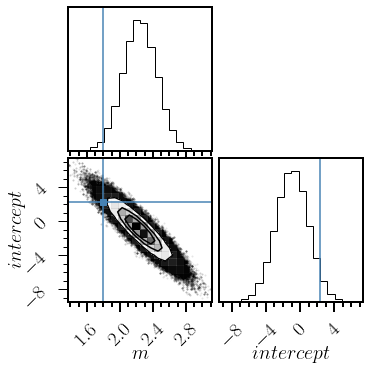

Fig 6: EMCEE with 100 chains of 100 steps  - generative model truth indicated in blue


In [15]:
#throw away the first 150 points and visualize the location of the chais at each step
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])
pl.show()
print ("Fig 6: EMCEE with {0:d} chains of {0:d} steps  ".format(nwalkers, nsteps) + 
       "- generative model truth indicated in blue")

In [16]:
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [17]:
mcmcRes = np.concatenate([m_mcmc, b_mcmc])
print ("MCMC result:\nslope\t\t{0:+.2f} ({1:.2f}, {2:.2f})\nintercept\t{3:.2f} ({4:.2f}, {5:.2f})".format(*mcmcRes))

MCMC result:
slope		+2.24 (0.20, 0.20)
intercept	-0.96 (1.92, 1.93)


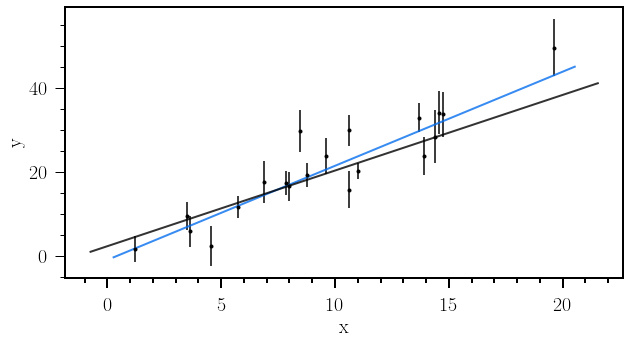

Figure 7: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.
In blue the model with MCMC best fit parameters, identified as the median of the joint posterior distributions, is indicated


In [18]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), 
        '-', alpha=0.8, lw=2, label="generative model")
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 
        'k-', alpha=0.8, lw=2, label="MCMC result")
pl.show()
print ("Figure 7: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.\n" + 
       "In blue the model with MCMC best fit parameters, " + 
       "identified as the median of the joint posterior distributions, is indicated")

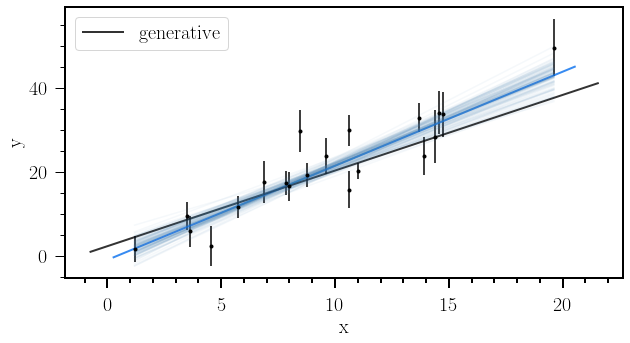

Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.
In blue model with the MCMC best fit parameters, identified as the median of the joint posterior distributions, is indicated.
In light blue shades the model with the best parameters for each chain is plotted


In [19]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), '-', alpha=0.8, lw=2)
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-', 
        alpha=0.8, lw=2, label="generative")
for m, b in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x, m*x+b, color="SteelBlue", alpha=0.05)
ax.legend(loc=2)
pl.show()
print ("Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.\n" + 
       "In blue model with the MCMC best fit parameters, "  + 
       "identified as the median of the joint posterior distributions, is indicated.\n" + 
       "In light blue shades the model with the best parameters for each chain is plotted")

# Comparison with analytical solution

In [78]:
# linear algebra solution
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.
In blue model with the MCMC best fit parameters, identified as the median of the joint posterior distributions, is indicated.
In light blue shades the model with the best parameters for each chain is plotted
In orange the anayltical solution (OLS) is indicated by a dashed line


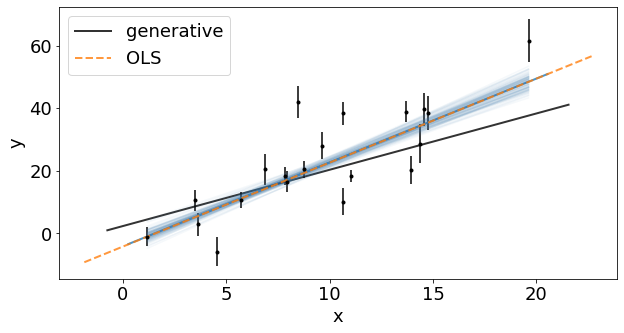

In [79]:
ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.errorbar(x, y, yerr=yerr, fmt='k.')
ax.plot(pl.xlim(), line(m_mcmc[0], b_mcmc[0],  np.array(pl.xlim())), '-', alpha=0.8, lw=2)
ax.plot(pl.xlim(), line(m_true, b_true,  np.array(pl.xlim())), 'k-',
        alpha=0.8, lw=2, label="generative")
for m, b in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x, m*x+b, color="SteelBlue", alpha=0.05)
ax.plot(pl.xlim(), line(m_ls, b_ls,  np.array(pl.xlim())), '--', 
        alpha=0.8, lw=2, label="OLS")
pl.legend();
print ("Figure 8: a line generative model and the data it generates with Poisson errors augmented by Gaussian errors.\n" + 
       "In blue model with the MCMC best fit parameters, "  + 
       "identified as the median of the joint posterior distributions, is indicated.\n" + 
       "In light blue shades the model with the best parameters for each chain is plotted\n" + 
       "In orange the anayltical solution (OLS) is indicated by a dashed line")

In [80]:
pos = [np.array([m_ls, b_ls]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))
sampler.run_mcmc(pos, nsteps);

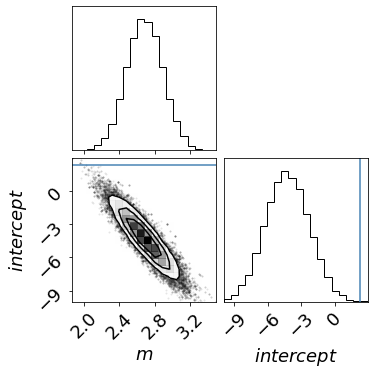

Fig 10: EMCEE with 100 chains of 100 steps  - generative model truth indicated in blue, the starting point was the OLS solution


In [81]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$m$","$intercept$"],
                      truths=[m_true, b_true])
pl.show()
print ("Fig 10: EMCEE with 100 chains of 100 steps  - generative model truth indicated in blue, the starting point was the OLS solution")
